In [1]:
import os
from pathlib import Path
import torch
from tqdm import tqdm
import warnings
import re
import keras
import librosa
import tensorflow as tf
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import random
import soundfile as sf
import shutil

### Use cuda acceleration (optional)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:

path = './AUDIO_DATA'

if os.path.exists('./augmented_train_dataset'):
    shutil.rmtree('./augmented_train_dataset')

if os.path.exists('./augmented_test_dataset'):
    shutil.rmtree('./augmented_test_dataset')

### Link your google drive storage if you are working on google colab (optional)  

In [4]:
path = '<your google drive path>'
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DurianAudios

In [5]:
seed = 41
random.seed(seed), np.random.seed(seed), tf.random.set_seed(seed)

(None, None, None)

In [6]:

AUDIO_PATH = Path("./AUDIO_DATA")
assert AUDIO_PATH.exists(), f"Audio path {AUDIO_PATH} does not exist."
AUDIO_LIST = list(AUDIO_PATH.glob("*"))
print(*AUDIO_LIST)

AUDIO_DATA\20240929_023338_Dona_75-85%output.wav AUDIO_DATA\20240929_023344_Dona_75-85%output.wav AUDIO_DATA\20240929_023348_Dona_75-85%output.wav AUDIO_DATA\20240929_023353_Dona_75-85%output.wav AUDIO_DATA\20240929_023359_Dona_75-85%output.wav AUDIO_DATA\20240929_023409_Dona_75-85%output.wav AUDIO_DATA\20240929_023414_Dona_75-85%output.wav AUDIO_DATA\20240929_023418_Dona_75-85%output.wav AUDIO_DATA\20240929_023426_Dona_75-85%output.wav AUDIO_DATA\20240929_023431_Dona_75-85%output.wav AUDIO_DATA\20240929_023435_Dona_75-85%output.wav AUDIO_DATA\20240929_023439_Dona_75-85%output.wav AUDIO_DATA\20240929_023443_Dona_75-85%output.wav AUDIO_DATA\20240929_023447_Dona_75-85%output.wav AUDIO_DATA\20240929_023501_Dona_75-85%output.wav AUDIO_DATA\20240929_023505_Dona_75-85%output.wav AUDIO_DATA\20240929_023509_Dona_75-85%output.wav AUDIO_DATA\20240929_023513_Dona_75-85%output.wav AUDIO_DATA\20240929_023517_Dona_75-85%output.wav AUDIO_DATA\20240929_023521_Dona_75-85%output.wav AUDIO_DATA\20240929_

In [7]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="PySoundFile failed.*")

audios_75_85: list[Path] = []
audios_95: list[Path] = []

def tri_audio(audio: Path):
  if(audio.name not in [*audios_75_85,*audios_95]):
    try:
      if(re.split('_|%',audio.name)[3] == "75-85"):
        audios_75_85.append(audio)
      else:
        audios_95.append(audio)
    except :
      print(audio.name)
for i in sorted(AUDIO_LIST):
  tri_audio(i)

In [8]:
from sklearn.model_selection import train_test_split

# Séparer la liste AUDIO_LIST en train et test avant toute data augmentation
train_files_1, test_files_1 = train_test_split(audios_95, test_size=0.2, random_state=42, shuffle=True)
train_files_2, test_files_2 = train_test_split(audios_75_85, test_size=0.2, random_state=42, shuffle=True)

train_files = train_files_1 + train_files_2
random.shuffle(train_files)
test_files = test_files_1 + test_files_2


In [9]:
len(train_files), len(test_files)

(73, 19)

In [10]:
train_files = [Path(i) for i in train_files]
test_files = [Path(i) for i in test_files]
assert False not in [i.exists() for i in train_files], "Some training files do not exist."
assert False not in [i.exists() for i in test_files], "Some testing files do not exist."

# **1. Data preparation**
---

In [11]:
# def load_audio(file_name, parent_dir=AUDIO_PATH):
#     if "aug" in file_name:
#         full_path = os.path.join("augmented_train_dataset", file_name)
#     elif "test" in file_name:
#         full_path = os.path.join("augmented_test_dataset", file_name)
#     else:
#         full_path = os.path.join("AUDIO_DATA", file_name)
#     y, sr = librosa.load(full_path, sr=None)
#     return y, sr

In [12]:
# path_good = sorted(Path("AUDIO_DATA").glob("*75-85%output.wav"))
# path_bad = sorted(Path("AUDIO_DATA").glob("*95-Ripeoutput.wav"))

# for p in [*path_good, *path_bad]:
#     if not p.is_file():
#         print(f"{p} NOT FOUND")

# **2. Data Augmentation**
---

In [13]:
augment = [
    AddGaussianNoise(min_amplitude=0.000001, max_amplitude=0.00001, p=0.5),
    TimeStretch(min_rate=0.99, max_rate=1.01, p=0.5),
    PitchShift(min_semitones=-0.1, max_semitones=0.1, p=0.5),
]

composed = Compose(augment)

In [14]:
out_train_path = Path("./augmented_train_dataset")

In [15]:
os.mkdir(out_train_path)

In [16]:
use_one = True

nb_copies = 10

for file_name, (wave, sr) in tqdm([(Path(audio_path).name, librosa.load(audio_path)) for audio_path in train_files]):
    for nb in range(nb_copies):
        chosen_aug = random.choice(augment) if use_one else composed
        wave_aug = chosen_aug(samples=wave, sample_rate=sr) #type: ignore
        out = os.path.join(out_train_path, f"{file_name}_aug{nb}.wav")
        sf.write(out, wave_aug, sr)


100%|██████████| 73/73 [00:11<00:00,  6.22it/s]


In [17]:
use_one = True
out_test_path = Path("./augmented_test_dataset")
os.mkdir(out_test_path)

In [18]:
nb_copies = 10

for file_name, (wave, sr) in tqdm([(Path(audio_path).name, librosa.load(audio_path)) for audio_path in test_files]):
    for nb in range(nb_copies):
        chosen_aug = random.choice(augment) if use_one else composed
        wave_aug = chosen_aug(samples=wave, sample_rate=sr) #type: ignore
        out = os.path.join(out_test_path, f"{file_name}_aug{nb}.wav")
        sf.write(out, wave_aug, sr)

100%|██████████| 19/19 [00:03<00:00,  5.97it/s]


# **3. Data and features extraction : MFCC**
---

In [19]:

# Liste des fichiers augmentés
augmented_train_files = sorted(Path(out_train_path).glob("*.wav"))
augmented_test_files = sorted(Path(out_test_path).glob("*.wav"))

# Les fichiers originaux du train
# train_files_names = [Path(f).name for f in train_files]
# Les fichiers du test
# test_files_names = [Path(f).name for f in test_files]
# Liste complète des fichiers d'entraînement (originaux + augmentés)
train_files_final = augmented_train_files + train_files
test_files_final = augmented_test_files + test_files


In [20]:
assert False not in list(map(lambda x: x.exists(), test_files_final))  
assert False not in list(map(lambda x: x.exists(), train_files_final))

In [21]:

print(f"{len(train_files_final)} fichiers pour le train")
print(f"{len(test_files_final)} fichiers pour le test")


803 fichiers pour le train
209 fichiers pour le test


In [22]:
from typing import Iterable


n_mfcc     = 40        # number of coefficients
n_fft      = 2048      # window size STFT
hop_length = 512

def compute_mfcc(files: Iterable[Path]) -> Iterable[np.ndarray]:
  for file in files:
      y, sr = librosa.load(file, sr=None)
      mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
      yield librosa.util.normalize(mfcc_features, axis=1)

In [23]:
mfcc_test = [*compute_mfcc(tqdm(test_files_final))]
mfcc_train = [*compute_mfcc(tqdm(train_files_final))]

100%|██████████| 803/803 [00:17<00:00, 45.45it/s] 


# **4. Audio dataset preparation (padding and trimming)**
---

Besides, the idea is to set a single length T_max (typically the maximum recorded value) and then, for each MFCC:  
*   If T_i < T_max → pad with columns of trailing zeros
*   If T_i > T_max → trim to keep only the first T_max frames  

In [24]:
# Pour le train
T_train = [mfcc.shape[1] for mfcc in mfcc_train]
print("Durée (train) :", *T_train)

# Pour le test
T_test = [mfcc.shape[1] for mfcc in mfcc_test]
print("Durée (test) :", *T_test)

# T_max commun pour le padding (on prend le max des deux)
T_max = max(T_train + T_test)
print(f'The maximum value of time is {T_max} ms')

Durée (train) : 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 122 125 125 125 125 125 125 125 125 125 125 129 129 129 129 129 129 129 129 129 129 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 137 137 137 137 137 137 137 137 137 137 124 124 124 124 124 124 124 124 124 124 123 123 123 123 123 123 123 123 123 123 121 121 121 121 121 121 121 121 121 121 122 122 122 122 122 122 122 122 122 122 120 120 120 120 120 120 120 120 120 120 133 133 133 133 133 133 133 133 133 133 124 124 124 124 124 124 124 124 124 124 136 136 136 136 136 136 136 136 136 136 131 131 131 131 131 131 131 131 131 131 122 122 122 122 122 122 122 122 122 122 121 121 121 121 121 121 121 121 121 121 122 122 122 122 122 122 122 122 122 122 134 134 134 134 134 134 134 134 134 134 124 124 124 124 124 124 124 124 124 124 123 123 123 123 123 123 123 123 123 123 131 131 131 131 131 131 131 131 131 131 136 136 136 136 136 136 136 136 136 136 134 134 134 134 134 134 

In this step, we ensure that all MFCCs have the same length by either padding them with zeros or trimming them to a fixed length, `T_max`. This is necessary to standardize the input size for the model.

In [25]:
def pad_mfccs(mfcc_list, T_max):
    mfcc_fixed = []
    for m in mfcc_list:
        T_i = m.shape[1]
        if T_i < T_max:
            pad_width = T_max - T_i
            m2 = np.pad(m,
                        pad_width=((0,0),   # no padding sur les coefficients
                        (0,pad_width)),     # padding à droite sur le temps
                        mode='constant',
                        constant_values=0)
        else:
            m2 = m[:, :T_max]
        mfcc_fixed.append(m2)
    return mfcc_fixed

# Pour le train
mfcc_train_fixed = pad_mfccs(mfcc_train, T_max)

# Pour le test
mfcc_test_fixed = pad_mfccs(mfcc_test, T_max)


# **5. Dataset formatting for model input**
---
At this stage, we will prepare our padded/truncated MFCCs into the right shape for our deep learning model (flattening, stacking, or reshaping as needed), and associate them with their corresponding labels.


In [26]:
x_train = np.stack(mfcc_train_fixed, axis=0)[..., np.newaxis]
x_test = np.stack(mfcc_test_fixed, axis=0)[..., np.newaxis]

print("X_train.shape =", x_train.shape)
print("X_test.shape =", x_test.shape)


X_train.shape = (803, 40, 273, 1)
X_test.shape = (209, 40, 273, 1)


In [27]:
len(mfcc_test_fixed)

209

# **6. Label and shuffle**
---

In [28]:
import re

def get_label(filename):
    base_name = re.sub(r'_aug\d+\.wav$', '', filename)
    if "75-85" in base_name:
        return 0  # unripe
    elif "95" in base_name:
        return 1  # ripe
    else:
        raise ValueError(f"Le nom de fichier ne permet pas d'extraire le label : {filename}")

# Recréer y_train avec la nouvelle fonction
y_train = np.array([get_label(f) for f in map(lambda x: x.name, train_files_final)])
y_test = np.array([get_label(f) for f in map(lambda x: x.name, test_files_final)])

# Calcul des poids de classes
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [29]:
len([i for i in y_train if i == 0]), len([i for i in y_train if i == 1])

(396, 407)

Shuffle training data ton ensure linear accuracy progress during training

In [30]:
# Shuffle le train pour éviter tout biais
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]
train_files_final = [train_files_final[i] for i in idx]# type: ignore

# **7. Building the classification model**
---
Now let's define our deep learning model. We'll use a simple Convolutional Neural Network (CNN) architecture suitable for audio classification.


In [31]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Input, BatchNormalization, Dropout, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.utils import plot_model


In [32]:
model = Sequential([
    Input(shape=x_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [33]:
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [34]:
def compile_model(model, learning_rate: int | None = None):
    if learning_rate is not None:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return opt
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [35]:
compile_model(model)

# **6. Model training**
---
Let's train the model on the training data and keep track of its performance.


In [36]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    shuffle=True,
)

Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.5187 - loss: 14.3541 - val_accuracy: 0.5093 - val_loss: 0.8249
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.5493 - loss: 0.9345 - val_accuracy: 0.5031 - val_loss: 4.0617
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5919 - loss: 0.6720 - val_accuracy: 0.5031 - val_loss: 6.7666
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.5931 - loss: 0.6532 - val_accuracy: 0.5031 - val_loss: 8.5934
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.6412 - loss: 0.6230 - val_accuracy: 0.5031 - val_loss: 10.2982
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.6012 - loss: 0.6334 - val_accuracy: 0.5031 - val_loss: 11.6758


In [37]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((803, 40, 273, 1), (803,), (209, 40, 273, 1), (209,))

# **7. Model evaluation**
---
We now evaluate the trained model on the test set, check the accuracy, and display a confusion matrix for detailed analysis.


In [38]:
loss, acc = model.evaluate(x_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4925 - loss: 1.0074


# **8. Results & analysis**
---
Let's analyze the results, discuss strengths and weaknesses, and try to interpret what the model is learning.


In [39]:
print("X_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

print("Répartition y_train :", np.unique(y_train, return_counts=True))
print("Répartition y_test :", np.unique(y_test, return_counts=True))

print("Premier fichier train:", train_files_final[0].name, "label:", y_train[0])
print("Premier fichier test:", test_files_final[0].name, "label:", y_test[0])

X_train.shape: (803, 40, 273, 1)
y_train.shape: (803,)
X_test.shape: (209, 40, 273, 1)
y_test.shape: (209,)
Répartition y_train : (array([0, 1]), array([396, 407]))
Répartition y_test : (array([0, 1]), array([ 99, 110]))
Premier fichier train: 20240929_023926_Dona_95-Ripeoutput.wav_aug5.wav label: 1
Premier fichier test: 20240929_023359_Dona_75-85%output.wav_aug0.wav label: 0


In [40]:
print("y_train repartition :", np.bincount(y_train))
print("y_test repartition :", np.bincount(y_test))

y_train repartition : [396 407]
y_test repartition : [ 99 110]


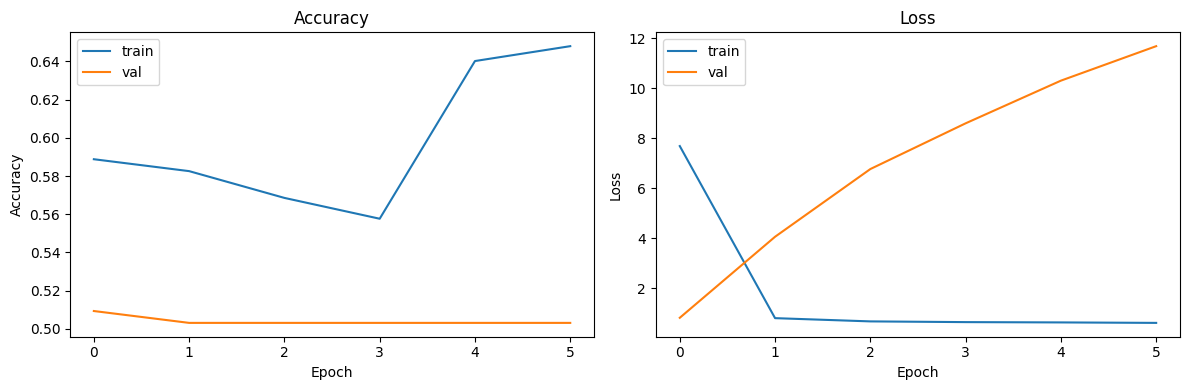

In [41]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


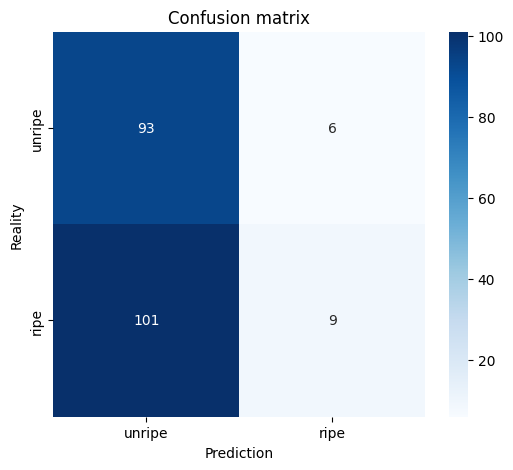

In [42]:

# Confusion matrix
y_prob = model.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ['unripe', 'ripe']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix")
plt.show()


In [43]:

print(classification_report(y_test, y_pred, target_names=labels))



              precision    recall  f1-score   support

      unripe       0.48      0.94      0.63        99
        ripe       0.60      0.08      0.14       110

    accuracy                           0.49       209
   macro avg       0.54      0.51      0.39       209
weighted avg       0.54      0.49      0.38       209



# **9. Save model**
---
Finally, we save our trained model for later use, and discuss possible improvements or future work.


In [44]:
# only execute the first time 
model_version_index = 4

In [45]:
# model.save(f"models/model_augmented_v{model_version_index}_({loss:.2f}, {acc:.2f})_.keras")
# model_version_index+=1

test